# Classification Problems

In [6]:
import pandas as pd

In [127]:
# parameters

global_seed=805

In [342]:
# add a column to represent the season

df = pd.read_csv("episode_word_counts.csv")
df['episode_tmp'] = df['Episode URL'].str[-7:-4].astype(int)-100

season = ['1'] * 25 + ['2'] * 22 + ['3'] * 25 + ['4'] * 26 + ['5'] * 26 + ['6'] * 26 + ['7'] * 26
epi_pos = [0] * int(df.shape[0]/2) + [1] * int(df.shape[0]/2)

df['season'] = season
df['epi_pos'] = epi_pos
print(df['epi_pos'])

0      0
1      0
2      0
3      0
4      0
      ..
171    1
172    1
173    1
174    1
175    1
Name: epi_pos, Length: 176, dtype: int64


In [312]:
# setting up ADA Boosting

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import numpy as np

## Predicting Season from the Word Count

I have performed ADA Boosting using both the default weak classifier 'Decision Tree', as well as using Gradient Boosting as the weak classifier. However, I have used multiple learning rates and n_estimators to determine the best set of parameters.

In [346]:
## obtaining the X and Y matrices

X = df.drop(columns=['Episode URL', 'season', 'epi_pos', 'episode_tmp'])
Y = df['season']

## test-train split (using a 70-30 split)

X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size=0.3, random_state=global_seed)

## build the ADA Boost model using default parameters

ada_default = AdaBoostClassifier(algorithm = "SAMME", random_state=global_seed)

## fit the model
model = ada_default.fit(X_train, y_train)

## test the model predictions
y_pred = model.predict(X_test)

## model accuracy (most simplest model)
print("Model Accuracy:", metrics.accuracy_score(y_test, y_pred))

Model Accuracy: 0.37735849056603776


Not bad accuracy to begin with. Let's now start tingling with the learning rate and n_estimators of this model.

In [348]:
## set up the range of parameters we want to test on
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 1, 1.5, 2],
    'n_estimators': [50, 75, 100, 150, 200]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with the parameter grid
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Test on the test data
y_pred = best_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Test Accuracy with Best Parameters:", accuracy)

Best Parameters: {'learning_rate': 0.5, 'n_estimators': 100}
Test Accuracy with Best Parameters: 0.39622641509433965


We were only able to improve the model by an accuracy percentage of about 2%.

In [322]:
## extracting the features which best predict the season. Using the best model as found above.

importances = best_model.feature_importances_

# Map feature importances to words
words = X.columns.to_numpy()
important_words = words[np.where(importances > 0)]  # Sort words by importance, in descending order

# top words to detect season
print("\n Top 10 important words for predicting season:\n")
for word in important_words:
    print(word)


 Top 10 important words for predicting season:

uss
captain
tasha
right
ready
frequencies
find
twenty
humanoid
crusher
wesley
judgment
number
ten
indeed
vanish
totally
disappear
pulaski


## Detecting First or Second Half

In [356]:
## using the same pipeline as before
## obtaining the X and Y matrices

X = df.drop(columns=['Episode URL', 'season', 'epi_pos', 'episode_tmp'])
Y = df['epi_pos']

## test-train split (using a 70-30 split)

X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size=0.3, random_state=global_seed)

## build the ADA Boost model using default parameters

ada_default = AdaBoostClassifier(algorithm = "SAMME", random_state=global_seed)

## fit the model
model = ada_default.fit(X_train, y_train)

## test the model predictions
y_pred = model.predict(X_test)

## model accuracy (most simplest model)
print("Model Accuracy:", metrics.accuracy_score(y_test, y_pred))


Model Accuracy: 0.8113207547169812


Now, that gives much better accuracy. Let's see if we can increase acccuracy by tuning parameters like before.

In [364]:
## set up the range of parameters we want to test on
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 1, 1.5, 2],
    'n_estimators': [50, 75, 100, 150, 200]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with the parameter grid
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Test on the test data
y_pred = best_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Test Accuracy with Best Parameters:", accuracy)

Best Parameters: {'learning_rate': 0.5, 'n_estimators': 200}
Test Accuracy with Best Parameters: 0.8301886792452831


As before, we are able to only increase the accuracy by about 2% with the tuning of the parameters. Thus, the best model is that shown above.

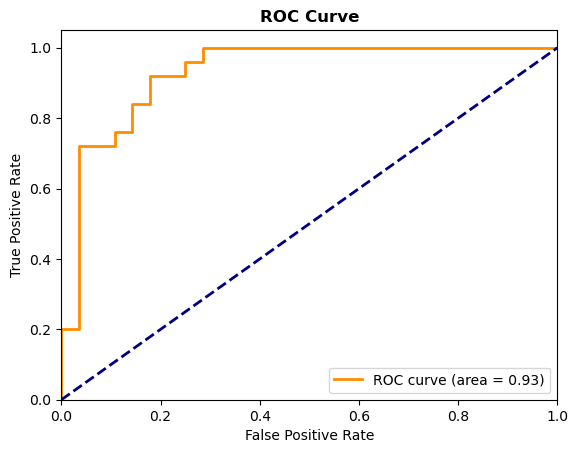

The AUC using this model: 0.93


<Figure size 640x480 with 0 Axes>

In [374]:
## obtaining metrics (ROC, AUC) for the above model

y_prob = best_model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)

roc_auc = metrics.auc(fpr, tpr)

## plotting the ROC curve

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontweight="bold")
plt.legend(loc='lower right')
plt.show()

plt.savefig("roc_curve.png", format="png", dpi=300)

print(f"The AUC using this model: {roc_auc:.2f}")